In [1]:
pip install statsmodels numpy pandas

In [2]:
pip install yfinance pandas

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import os

# --- Configuration ---
TICKER = 'SPY'
START_DATE = '2018-01-01'
END_DATE = '2024-01-01'
OUTPUT_DIR = 'DATA'

# --- Setup ---
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print(f"-> Starting project setup for Single-Index Mean Reversion on {TICKER}")

# --- Data Download (Download Open and Close) ---
try:
    # We now download Open and Close prices
    data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
    price_data = data[['Open', 'Close']].copy()
    price_data.columns = [f'{TICKER}_Open', f'{TICKER}_Close']

    print(f"-> Data for {TICKER} downloaded successfully (Open & Close). Total rows: {len(price_data)}")

except Exception as e:
    print(f"Error downloading data: {e}")
    price_data = pd.DataFrame()

-> Starting project setup for Single-Index Mean Reversion on SPY


[*********************100%***********************]  1 of 1 completed

-> Data for SPY downloaded successfully (Open & Close). Total rows: 1509


In [4]:
WINDOW_MA = 100    # Mean Reversion window (Shorter window for quicker response)
WINDOW_TREND = 250 # Long-term trend filter (Prevents trading against major trends)
WINDOW_Z = 60      # Rolling window for Z-score standard deviation calculation
ENTRY_Z = 1.25     # Entry threshold: Enter trade when price is far enough from the mean
EXIT_Z = 0.25      # Exit threshold: Exit trade when price reverts close to the mean
STOP_Z = 3.0       # Critical risk control: Stop-Loss Z-score threshold


def generate_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates trading signals based on Close price, filtered by a super-long-term trend.
    """

    # Use Close price for signal generation
    CLOSE_COL = f'{TICKER}_Close'

    # 1. Calculate Moving Averages and Deviation ("Spread")
    df['MA'] = df[CLOSE_COL].rolling(window=WINDOW_MA).mean()
    df['Trend_MA'] = df[CLOSE_COL].rolling(window=WINDOW_TREND).mean()
    df['Spread'] = df[CLOSE_COL] - df['MA']

    df = df.dropna(subset=['MA', 'Spread', 'Trend_MA']).copy()

    # 2. Calculate Z-Score
    df['Spread_Std'] = df['Spread'].rolling(window=WINDOW_Z).std()
    df['Z_Score'] = df['Spread'] / df['Spread_Std']

    # --- 3. Signal Generation with Trend Filter ---
    df['Signal'] = 0

    # Long Position: Z < -ENTRY_Z AND Price > Trend_MA
    df.loc[(df['Z_Score'] < -ENTRY_Z) & (df[CLOSE_COL] > df['Trend_MA']), 'Signal'] = 1

    # Short Position: Z > ENTRY_Z AND Price < Trend_MA
    df.loc[(df['Z_Score'] > ENTRY_Z) & (df[CLOSE_COL] < df['Trend_MA']), 'Signal'] = -1

    # Exit Position
    df.loc[np.abs(df['Z_Score']) < EXIT_Z, 'Signal'] = 0

    # --- 4. Position Management & Stop-Loss ---

    df['Position_Held'] = df['Signal'].ffill().fillna(0)
    df.loc[np.abs(df['Z_Score']) >= STOP_Z, 'Position_Held'] = 0

    df['Signal'] = df['Position_Held']

    print(f"-> Signals generated: MA={WINDOW_MA} days, Trend Filter={WINDOW_TREND} days, Stop-Loss Z={STOP_Z}")
    return df

# --- Main Execution ---
if not price_data.empty:
    strategy_df = generate_signals(price_data)

    # Only save necessary columns: Open/Close prices and the Signal/Z_Score
    cols_to_save = [f'{TICKER}_Open', f'{TICKER}_Close', 'Signal', 'Z_Score']
    strategy_df = strategy_df[cols_to_save]

    OUTPUT_FILE = os.path.join(OUTPUT_DIR, f'strategy_data_{TICKER}.csv')
    strategy_df.to_csv(OUTPUT_FILE)
    print(f"Strategy data saved for backtesting: {OUTPUT_FILE}")

-> Signals generated: MA=100 days, Trend Filter=250 days, Stop-Loss Z=3.0
Strategy data saved for backtesting: DATA/strategy_data_SPY.csv


In [5]:
INPUT_STRATEGY_FILE = os.path.join(OUTPUT_DIR, f'strategy_data_{TICKER}.csv')
TRANSACTION_COST = 0.001
SLIPPAGE_COST = 0.0001 # 0.01% slippage penalty on trade days
INITIAL_CAPITAL = 10000

# New: Define the split point for In-Sample (Training) vs. Out-of-Sample (Testing)
TRAIN_END_DATE = '2023-01-01'

def load_strategy_data(file_pattern: str) -> pd.DataFrame:
    """Loads the strategy data file."""
    try:
        data = pd.read_csv(file_pattern, index_col=0, parse_dates=True)
        print(f"-> Strategy data loaded successfully. ({TICKER})")
        return data
    except FileNotFoundError:
        print(f"Error: Strategy data not found at {file_pattern}. Please check the filename.")
        return pd.DataFrame()

def run_backtest(df: pd.DataFrame, initial_capital: float, t_cost: float, s_cost: float) -> pd.DataFrame:
    """
    Simulates the trades with execution realism (Open price) and slippage.
    """
    df = df.dropna().copy()

    # NEW: Asset return is calculated from next day's OPEN price
    # We use today's open and next day's open for realistic trade entry/exit pricing
    # Shift(1) applies today's signal to tomorrow's returns/price action.
    OPEN_COL = f'{TICKER}_Open'

    # Asset Return: (Tomorrow's Open - Today's Open) / Today's Open
    df['Asset_Return'] = df[OPEN_COL].pct_change().shift(-1).fillna(0)

    # Position: Use yesterday's signal for TODAY's trade (shifted returns handle price)
    df['Position'] = df['Signal'].ffill().shift(1).fillna(0)

    # Daily Strategy Return (Position * Asset Return)
    df['Daily_Return'] = df['Position'] * df['Asset_Return']

    # Account for transaction costs and SLIPPAGE only on days a trade changes position
    df['Trade_Change'] = (df['Position'].diff() != 0).astype(int)

    # Cost now includes base transaction fee + slippage penalty
    df['Cost'] = df['Trade_Change'] * (t_cost + s_cost)

    # Final Daily Return after cost
    df['Strategy_Return'] = df['Daily_Return'] - df['Cost']

    # Calculate Equity Curve
    df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()
    df['Equity_Curve'] = initial_capital * df['Cumulative_Return']

    return df.dropna()

def calculate_metrics(df: pd.DataFrame) -> dict:
    """Calculates key performance metrics."""
    total_return = (df['Cumulative_Return'].iloc[-1] - 1)
    annual_return = (1 + total_return) ** (252 / len(df)) - 1
    annual_volatility = df['Strategy_Return'].std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan
    df['HighWaterMark'] = df['Equity_Curve'].cummax()
    max_drawdown = (1 - (df['Equity_Curve'] / df['HighWaterMark'])).max()

    return {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{annual_return * 100:.2f}%",
        "Annualized Volatility": f"{annual_volatility * 100:.2f}%",
        "Sharpe Ratio (Annualized)": f"{sharpe_ratio:.2f}",
        "Maximum Drawdown": f"{max_drawdown * 100:.2f}%",
        "Total Trades": df['Trade_Change'].sum() / 2
    }

def print_metrics(df: pd.DataFrame, metrics: dict, title: str):
    print("\n" + "="*50)
    print(f"{title}:")
    print("="*50)
    for key, value in metrics.items():
        print(f"{key:<30}: {value}")
    print("="*50)

# --- Main Execution with Train/Test Split ---
if __name__ == "__main__":

    strategy_df = load_strategy_data(INPUT_STRATEGY_FILE)

    if not strategy_df.empty:

        # 1. SPLIT DATA: In-Sample (Train) and Out-of-Sample (Test)
        df_train = strategy_df[strategy_df.index < TRAIN_END_DATE].copy()
        df_test = strategy_df[strategy_df.index >= TRAIN_END_DATE].copy()

        print(f"\n-> Train Period: {df_train.index.min().date()} to {df_train.index.max().date()}")
        print(f"-> Test Period: {df_test.index.min().date()} to {df_test.index.max().date()}")
        print("-> Backtest simulation completed.")

        # 2. RUN BACKTESTS
        performance_df_train = run_backtest(df_train, INITIAL_CAPITAL, TRANSACTION_COST, SLIPPAGE_COST)
        performance_df_test = run_backtest(df_test, performance_df_train['Equity_Curve'].iloc[-1], TRANSACTION_COST, SLIPPAGE_COST)

        # 3. CONSOLIDATE RESULTS
        final_performance_df = pd.concat([performance_df_train, performance_df_test])

        # 4. CALCULATE AND PRINT METRICS
        metrics_train = calculate_metrics(performance_df_train)
        metrics_test = calculate_metrics(performance_df_test)
        metrics_full = calculate_metrics(final_performance_df)

        print_metrics(performance_df_train, metrics_train, "IN-SAMPLE (TRAIN) PERFORMANCE")
        print_metrics(performance_df_test, metrics_test, "OUT-OF-SAMPLE (TEST) PERFORMANCE")
        print_metrics(final_performance_df, metrics_full, "FULL PERIOD (2018-2024) PERFORMANCE")


-> Strategy data loaded successfully. (SPY)

-> Train Period: 2018-12-28 to 2022-12-30
-> Test Period: 2023-01-03 to 2023-12-29
-> Backtest simulation completed.

IN-SAMPLE (TRAIN) PERFORMANCE:
Total Return                  : -0.11%
Annualized Return             : -0.03%
Annualized Volatility         : 1.72%
Sharpe Ratio (Annualized)     : -0.02
Maximum Drawdown              : 1.82%
Total Trades                  : 3.5

OUT-OF-SAMPLE (TEST) PERFORMANCE:
Total Return                  : 1.02%
Annualized Return             : 1.03%
Annualized Volatility         : 3.80%
Sharpe Ratio (Annualized)     : 0.27
Maximum Drawdown              : 3.22%
Total Trades                  : 5.5

FULL PERIOD (2018-2024) PERFORMANCE:
Total Return                  : 1.02%
Annualized Return             : 0.21%
Annualized Volatility         : 2.31%
Sharpe Ratio (Annualized)     : 0.09
Maximum Drawdown              : 3.22%
Total Trades                  : 9.0


Generating Final Equity Curve Plot...


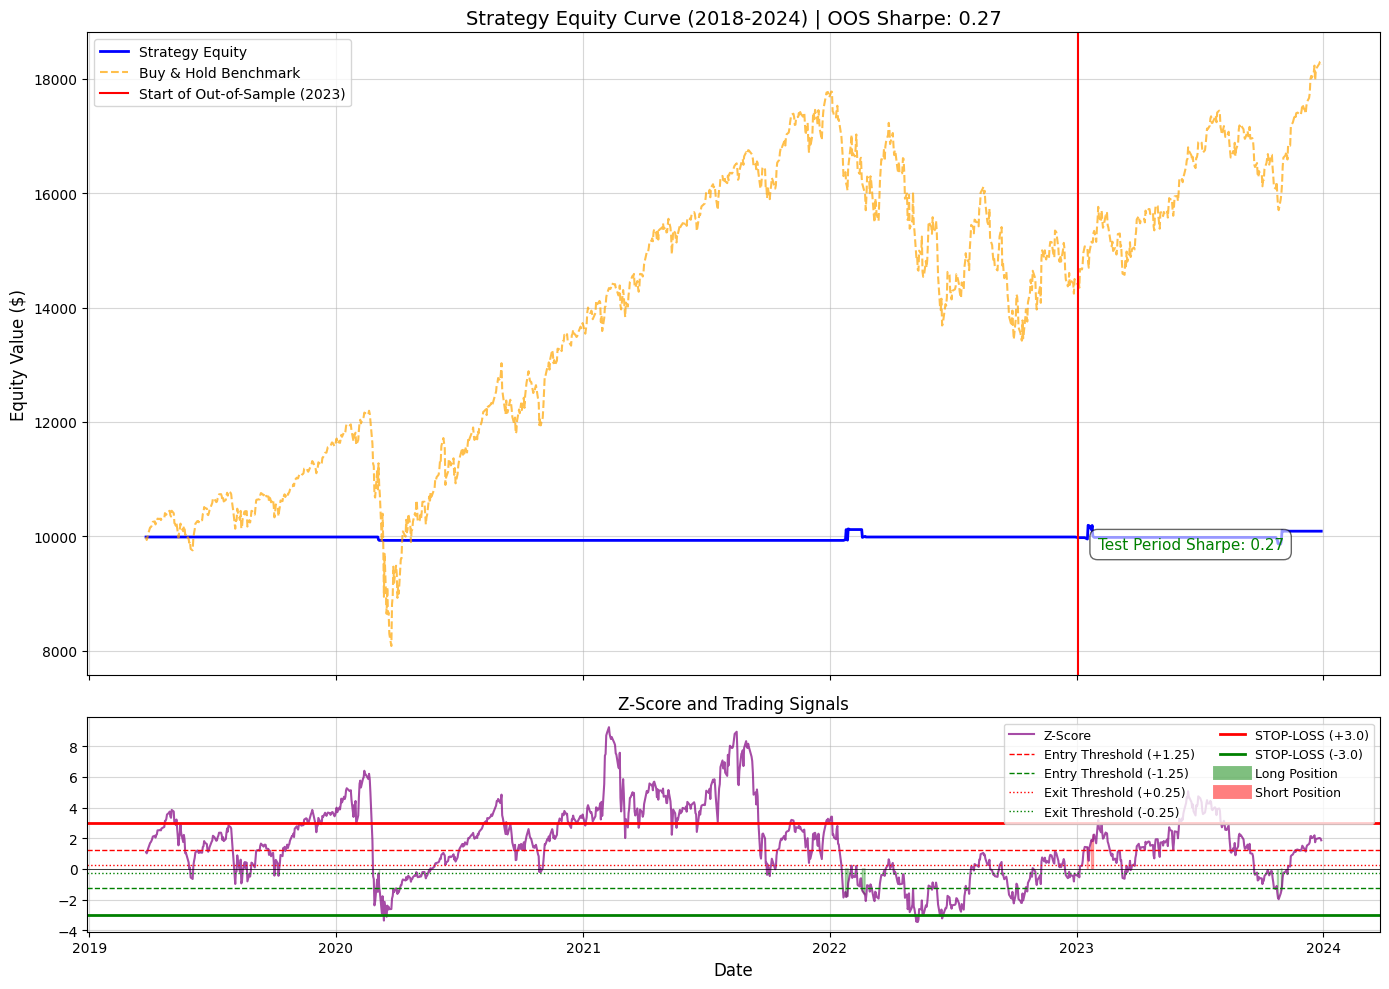

In [6]:
def plot_results(df: pd.DataFrame, metrics: dict, split_date: str):
    """Generates visualizations, highlighting the Train/Test split and Benchmark."""

    TICKER = 'SPY'
    # Define parameters here for clear labeling in Plot 2
    ENTRY_Z = 1.25
    EXIT_Z = 0.25
    STOP_Z = 3.0

    # 1. Benchmark Calculation (Buy & Hold)
    buy_hold_returns = df[f'{TICKER}_Close'].pct_change().fillna(0)
    buy_hold_cumulative = (1 + buy_hold_returns).cumprod() * df['Equity_Curve'].iloc[0]

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # --- Plot 1: Equity Curve with Benchmark ---

    axes[0].plot(df['Equity_Curve'], label='Strategy Equity', color='blue', linewidth=2)
    axes[0].plot(buy_hold_cumulative, label='Buy & Hold Benchmark', color='orange', linestyle='--', alpha=0.7)

    # Highlight the Train/Test Split
    split_datetime = pd.to_datetime(split_date)
    test_start_index = df.index.searchsorted(split_datetime)
    test_equity = df.iloc[test_start_index:]['Equity_Curve']

    axes[0].axvline(df.index[test_start_index], color='red', linestyle='-', linewidth=1.5, label='Start of Out-of-Sample (2023)')

    # Annotate Key Metrics (Focus on the Test Period)
    axes[0].text(df.index[test_start_index + 20], test_equity.iloc[0] * 0.98,
                  f'Test Period Sharpe: {float(metrics["Sharpe Ratio (Annualized)"]):.2f}',
                  fontsize=11, color='green', bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.5'))

    axes[0].set_title(f'Strategy Equity Curve (2018-2024) | OOS Sharpe: {float(metrics["Sharpe Ratio (Annualized)"]):.2f}', fontsize=14)
    axes[0].set_ylabel('Equity Value ($)', fontsize=12)
    axes[0].legend(loc='upper left')
    axes[0].grid(True, alpha=0.5)

    # --- Plot 2: Z-Score and Trading Signals ---

    axes[1].plot(df['Z_Score'], label='Z-Score', color='purple', alpha=0.7)

    # 1. Entry Thresholds (Positive and Negative)
    axes[1].axhline(ENTRY_Z, color='red', linestyle='--', linewidth=1, label=f'Entry Threshold (+{ENTRY_Z})')
    axes[1].axhline(-ENTRY_Z, color='green', linestyle='--', linewidth=1, label=f'Entry Threshold (-{ENTRY_Z})')

    # 2. Exit Thresholds (Positive and Negative)
    axes[1].axhline(EXIT_Z, color='red', linestyle=':', linewidth=1, label=f'Exit Threshold (+{EXIT_Z})')
    axes[1].axhline(-EXIT_Z, color='green', linestyle=':', linewidth=1, label=f'Exit Threshold (-{EXIT_Z})')

    # 3. Stop-Loss Lines (Critical)
    axes[1].axhline(STOP_Z, color='red', linestyle='-', linewidth=2, label=f'STOP-LOSS (+{STOP_Z})')
    axes[1].axhline(-STOP_Z, color='green', linestyle='-', linewidth=2, label=f'STOP-LOSS (-{STOP_Z})')

    # Indicate Long/Short Positions (Color fills)
    # Add dummy plots for the fills to appear in the legend
    axes[1].plot([], [], color='green', alpha=0.5, linewidth=10, label='Long Position')
    axes[1].plot([], [], color='red', alpha=0.5, linewidth=10, label='Short Position')

    axes[1].fill_between(df.index, 0, df['Z_Score'], where=df['Position'] == 1, color='green', alpha=0.3, label='_nolegend_')
    axes[1].fill_between(df.index, 0, df['Z_Score'], where=df['Position'] == -1, color='red', alpha=0.3, label='_nolegend_')

    axes[1].set_title('Z-Score and Trading Signals', fontsize=12)
    axes[1].axhline(0, color='black', linewidth=0.5)
    axes[1].grid(True, alpha=0.5)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].legend(loc='upper right', ncol=2, fontsize=9)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("Generating Final Equity Curve Plot...")
    plot_results(final_performance_df, metrics_test, TRAIN_END_DATE)